In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time
import random
import scipy

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.decomposition import PCA
from numpy.fft import fftn

## Homemade code imports
import metrics

data_dir = '/run/media/mnewlin/_userdata/uhnds/'
original_netflow_data_dir = data_dir + 'network/extracted/'
original_netflow_file = 'netflow_day-02'
fake_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/fake/'
real_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/real/'
real_file = 'netflow_day-02'

In [11]:
"""
    Function to read in a single real sample from a given directory based
    on the desired length of the sample.
"""
def load_real_sample(sample_num, sample_length=100):

    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1
        
    load_file = real_file + '_sample_{}.txt'.format(sample_num)
    filename = real_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    return df

In [12]:
"""
    Function to read in a single fake sample from a given directory based
    on the desired length of the sample.
"""
def load_fake_sample(sample_num, sample_length=100):
    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1

    load_file = real_file + '_random_sample_{}.txt'.format(sample_num)
    filename = fake_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    return df

In [13]:
def load_n_samples(real=True, sample_length=100, num_samples=100, random_state=69):
    data = pd.DataFrame()
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
        
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = data.append(load_real_sample(sample_length=sample_length, sample_num=num))
    else:
        for num in sample_list:
            data = data.append(load_fake_sample(sample_length=sample_length, sample_num=num))
    return data

In [14]:
def create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    if ratio == 0:
        return load_n_samples(real=True, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    elif ratio == 1:
        return load_n_samples(real=False, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    real = load_n_samples(real=True, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    fake = load_n_samples(real=False, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    real_samples = real.sample(frac=1-ratio, random_state=random_state)
    fake_samples = real.sample(frac=ratio, random_state=random_state)
    samples = real_samples.append(fake_samples)
    return samples

In [15]:
def alt_create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    #print(int(np.around((1-ratio)*num_samples)))
    #print(int(np.around((ratio)*num_samples)))
    real = load_n_samples(real=True, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    fake = load_n_samples(real=False, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    bound_val_real = np.around(((1-ratio)*num_samples*sample_length), decimals=2)
    bound_val_fake = np.around((ratio)*num_samples*sample_length, decimals=2)
    bound_val_real = int(bound_val_real)
    bound_val_fake = int(bound_val_fake)
    #print(bound_val_real)
    #print(bound_val_fake)
    real_samples = real.iloc[:bound_val_real]
    fake_samples = real.iloc[:bound_val_fake]
    samples = real_samples.append(fake_samples)
    return samples


In [16]:
#fake_samples = load_n_samples(real=False, sample_length=100,num_samples=10)
#display(fake_samples.describe())

In [17]:
#mix_samples = create_sample_mix(ratio=0.1, sample_length=100, num_samples=100)
#display(fake_samples.describe())

In [18]:
#real_samples = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=42)
#real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=333)

## Alternate Approach

In [20]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=100,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=69)
fake_samples_2 = load_n_samples(real=False, sample_length=100,num_samples=100, random_state=69)

Sr1 = np.sqrt(np.array(real_samples).astype(np.float64))
Sr2 = np.sqrt(np.array(fake_samples).astype(np.float64))
S_2 = np.sqrt(np.array(real_samples_2).astype(np.float64))
G_2 = np.sqrt(np.array(fake_samples_2).astype(np.float64))

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
#d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
#print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
#d0_bd = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='bd')
#print("Bhattacharyya: ", d0_bd)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)


True
True
lp, p=0.75, r=0.75:  941310.3412030247
lp, p=0.5, r=0.5:  19518366.92255278
euclidean:  23686.231549631062
cosine:  0.19654047930520552
Mahalanobis:  4.162158326183013
chi:  1.830768977899585e+299
wasserstein:  2033.7699012212936
Entropy:  0.7568482498067851
Perplexity:  3.9613900532202218
MMD:  0.40624191875541144


In [13]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
#bd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.sqrt(np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=42)).astype(np.float64))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.sqrt(np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=69)).astype(np.float64))
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    #d_bd = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='bd')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    #bd_scores = np.append(bd_scores, d_bd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [14]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

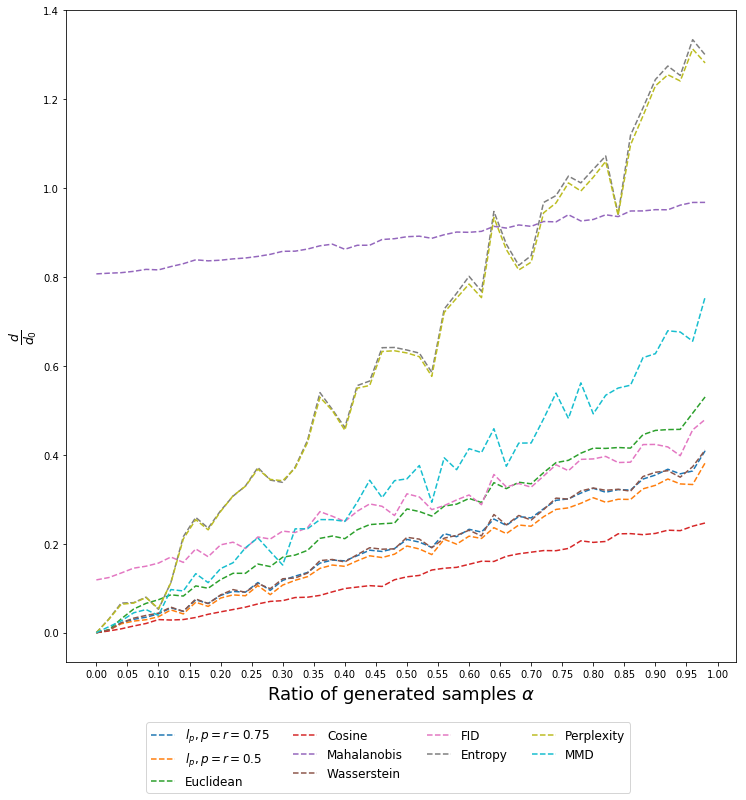

In [15]:
fig = plt.figure(figsize=(12,12))
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '--', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Ratio of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.2))
plt.savefig('figures/discriminative/eps/sqrt_100_100.eps')
plt.savefig('figures/discriminative/png/sqrt_100_100.png')
plt.show()

## Alt Approach Sqrt 100-1000

In [46]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=1)
fake_samples = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=1)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=2)
fake_samples_2 = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=2)

Sr1 = np.sqrt(np.array(real_samples).astype(np.float64))
Sr2 = np.sqrt(np.array(fake_samples).astype(np.float64))
S_2 = np.sqrt(np.array(real_samples_2).astype(np.float64))
G_2 = np.sqrt(np.array(fake_samples_2).astype(np.float64))

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_man = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
print("lp, p=1, r=1: ", d0_man)
d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
#d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
#print("FID: ", d0_fid)
d0_ent_std = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=True)
print("Standardized Entropy: ", d0_ent_std)
d0_perp_std = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=True)
print("Standardized Perplexity: ", d0_perp_std)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
lp, p=1, r=1:  198526.61698561913
lp, p=0.75, r=0.75:  889819.35105986
lp, p=0.5, r=0.5:  18470675.094878744
euclidean:  22469.98454923309
cosine:  0.20395520729621824
Mahalanobis:  3.48632165770831
wasserstein:  0.22099725862092884
Standardized Entropy:  0.15643769023978502
Standardized Perplexity:  0.15753590260341815
Entropy:  0.7204221870570983
Perplexity:  3.7687838829091294
MMD:  0.40073525880465516


In [47]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
#fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
ent_scores_std = np.array([])
perp_scores_std = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.sqrt(np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=1)).astype(np.float64))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.sqrt(np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=2)).astype(np.float64))
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_man = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    #d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent_std = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=True)
    d_perp_std = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=True)
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    man_scores = np.append(man_scores, d_man)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    #fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    ent_scores_std = np.append(ent_scores_std, d_ent_std)
    perp_scores_std = np.append(perp_scores_std, d_perp_std)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [48]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
#normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
#normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
#normalized_ent_std = ent_scores_std/d0_ent_std
#normalized_perp_std = perp_scores_std/d0_perp_std
normalized_mmd = mmd_scores/d0_mmd
normalized_man = man_scores/d0_man

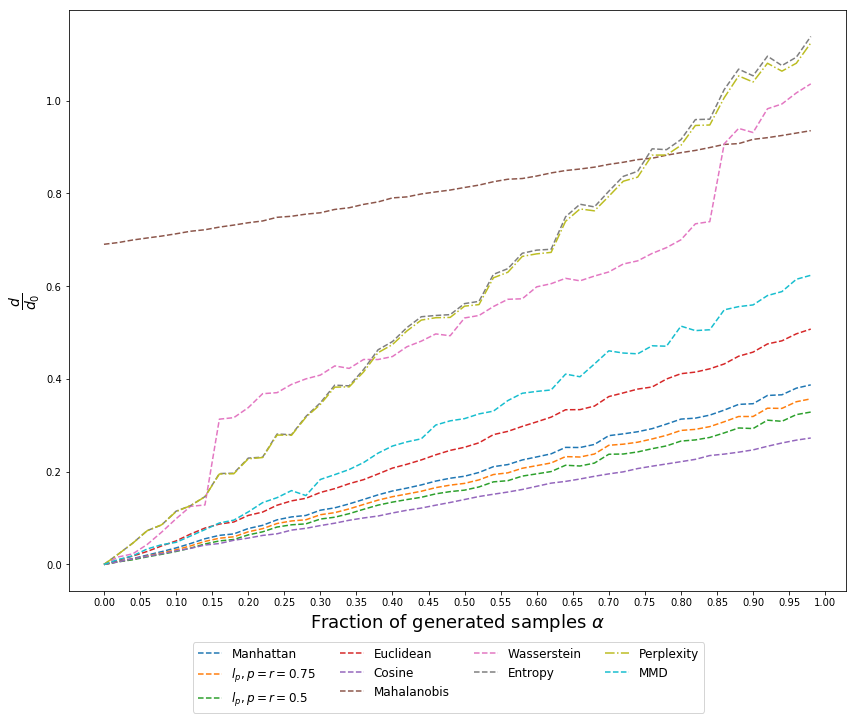

In [68]:
fig = plt.figure(figsize=(12,10))
plt.plot(alphagrid, normalized_man, '--', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
#plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '-.', label='Perplexity')
#plt.plot(alphagrid, normalized_ent_std, '--', label='Entropy')
#plt.plot(alphagrid, normalized_perp_std, '-.', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=20)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.16,-0.21))
plt.tight_layout()
plt.savefig('figures/discriminative/eps/sqrt_100_1000.eps')
plt.savefig('figures/discriminative/png/sqrt_100_1000.png')
plt.show()

## Alt Approach Sqrt 1000-1000

In [70]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=1)
fake_samples = load_n_samples(real=False, sample_length=1000,num_samples=1000, random_state=1)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=2)
fake_samples_2 = load_n_samples(real=False, sample_length=1000,num_samples=1000, random_state=2)

Sr1 = np.sqrt(np.array(real_samples).astype(np.float64))
Sr2 = np.sqrt(np.array(fake_samples).astype(np.float64))
S_2 = np.sqrt(np.array(real_samples_2).astype(np.float64))
G_2 = np.sqrt(np.array(fake_samples_2).astype(np.float64))

num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_man = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
print("lp, p=1, r=1: ", d0_man)
d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
#d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
#print("FID: ", d0_fid)
d0_ent_std = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=True)
print("Standardized Entropy: ", d0_ent_std)
d0_perp_std = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=True)
print("Standardized Perplexity: ", d0_perp_std)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
lp, p=1, r=1:  1187901.7868386065
lp, p=0.75, r=0.75:  11503962.324066766
lp, p=0.5, r=0.5:  1110242046.9935799
euclidean:  41887.527236885726
cosine:  0.29373631321947696
Mahalanobis:  3.472822263194583
wasserstein:  0.25904974385565827
Standardized Entropy:  0.06531501477299564
Standardized Perplexity:  0.06584592653024271
Entropy:  0.4511801380949568
Perplexity:  8.378882151651432
MMD:  0.4419569050041664


In [73]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.sqrt(np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 1000, random_state=1)).astype(np.float64))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.sqrt(np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 1000, random_state=2)).astype(np.float64))
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_man = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1, r=1)
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    #d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    #fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    man_scores = np.append(man_scores, d_man)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [74]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
normalized_wass = wass_scores/d0_wass
#normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

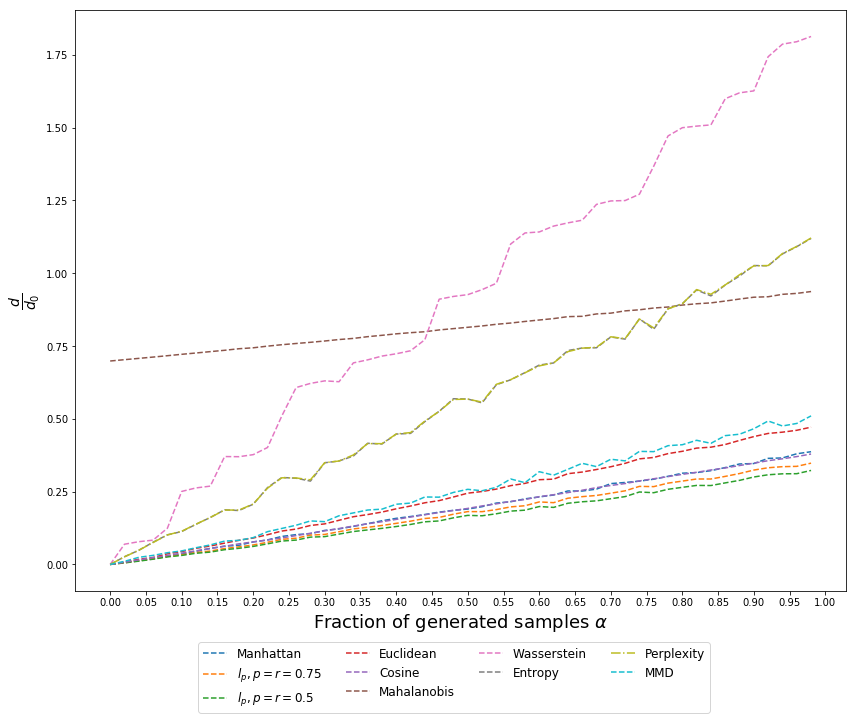

In [75]:
fig = plt.figure(figsize=(12,10))
plt.plot(alphagrid, normalized_man, '--', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
#plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '-.', label='Perplexity')
#plt.plot(alphagrid, normalized_ent_std, '--', label='Entropy')
#plt.plot(alphagrid, normalized_perp_std, '-.', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=20)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.16,-0.21))
plt.tight_layout()
plt.savefig('figures/discriminative/eps/sqrt_1000_1000.eps')
plt.savefig('figures/discriminative/png/sqrt_1000_1000.png')
plt.show()

## Alt Approach Sqrt 1000-1000

## Alt Approach Log Transform 100-100

In [29]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=100,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=69)
fake_samples_2 = load_n_samples(real=False, sample_length=100,num_samples=100, random_state=69)

Sr1 = np.log(np.array(real_samples+1).astype(np.float64))
Sr2 = np.log(np.array(fake_samples+1).astype(np.float64))
S_2 = np.log(np.array(real_samples_2+1).astype(np.float64))
G_2 = np.log(np.array(fake_samples_2+1).astype(np.float64))

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
lp, p=0.75, r=0.75:  1671.3005932624055
lp, p=0.5, r=0.5:  34422.4943912658
euclidean:  41.61479803453628
cosine:  0.08376825551306893
Mahalanobis:  4.433362833857009
wasserstein:  3.502404218300799
FID:  17.399365377567506
Entropy:  0.971252725184983
Perplexity:  5.627046975118841
MMD:  0.3807826523563542


In [30]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.log(np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=42)+1).astype(np.float64))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.log(np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=69)+1).astype(np.float64))
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [31]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

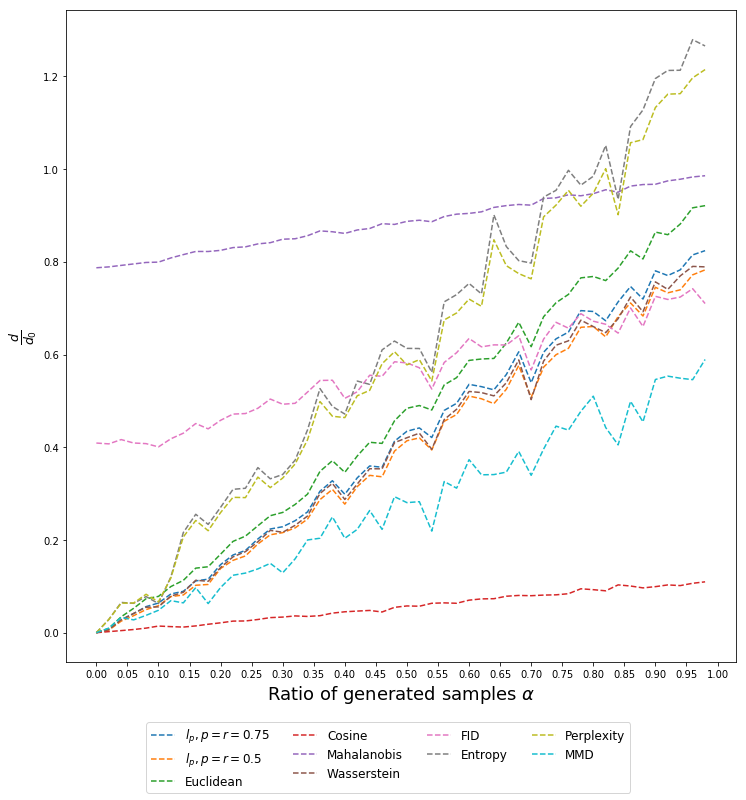

In [33]:
fig = plt.figure(figsize=(12,12))
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '--', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Ratio of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.2))
plt.savefig('figures/discriminative/eps/log_100_100.eps')
plt.savefig('figures/discriminative/png/log_100_100.png')
plt.show()

## Alt Approach Log Transform 100-1000

In [76]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=1)
fake_samples = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=1)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=2)
fake_samples_2 = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=2)

Sr1 = np.log(np.array(real_samples+1).astype(np.float64))
Sr2 = np.log(np.array(fake_samples+1).astype(np.float64))
S_2 = np.log(np.array(real_samples_2+1).astype(np.float64))
G_2 = np.log(np.array(fake_samples_2+1).astype(np.float64))

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_man = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1, r=1)
print("Manhattan: ", d0_lp)
d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
#d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
#print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
Manhattan:  11503962.324066766
lp, p=0.75, r=0.75:  1570.205999732949
lp, p=0.5, r=0.5:  32175.81779365036
euclidean:  39.774594214125784
cosine:  0.07740060106490304
Mahalanobis:  4.486674706759275
wasserstein:  3.8294068853919514
Entropy:  0.9505798183068773
Perplexity:  5.512663065828401
MMD:  0.36003716552354187


In [77]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.log(np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=1)+1).astype(np.float64))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.log(np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=2)+1).astype(np.float64))
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_man = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1, r=1)
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    #d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    #fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    man_scores = np.append(man_scores, d_man)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [78]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
normalized_man = man_scores/d0_man
normalized_wass = wass_scores/d0_wass
#normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

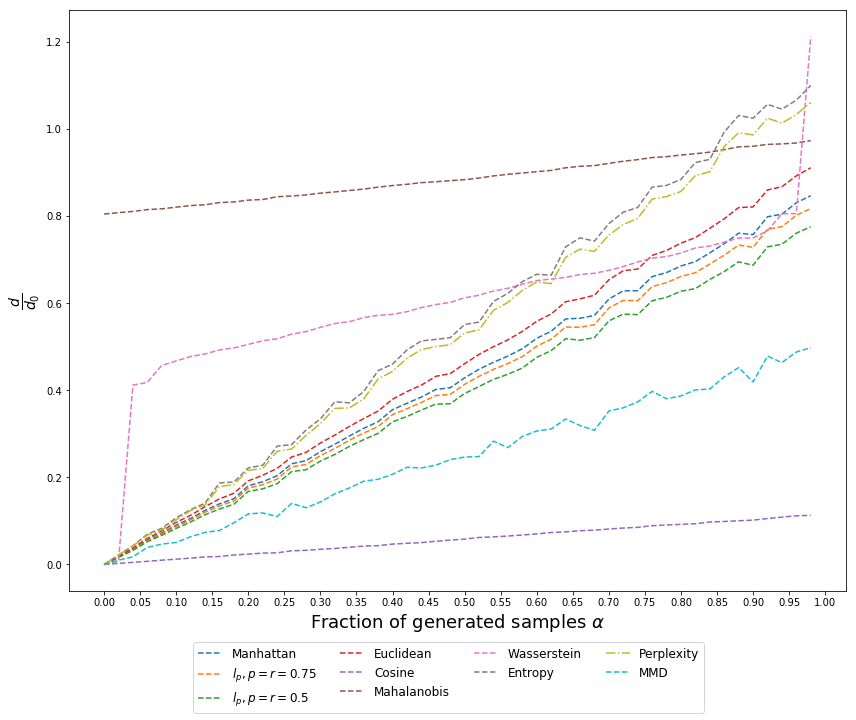

In [79]:
fig = plt.figure(figsize=(12,10))
plt.plot(alphagrid, normalized_man, '--', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
#plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '-.', label='Perplexity')
#plt.plot(alphagrid, normalized_ent_std, '--', label='Entropy')
#plt.plot(alphagrid, normalized_perp_std, '-.', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=20)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.16,-0.21))
plt.tight_layout()
plt.savefig('figures/discriminative/eps/log_100_1000.eps')
plt.savefig('figures/discriminative/png/log_100_1000.png')
plt.show()

## Alt Approach Log Transform 1000-1000

In [80]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=1)
fake_samples = load_n_samples(real=False, sample_length=1000,num_samples=1000, random_state=1)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=2)
fake_samples_2 = load_n_samples(real=False, sample_length=1000,num_samples=1000, random_state=2)

Sr1 = np.log(np.array(real_samples+1).astype(np.float64))
Sr2 = np.log(np.array(fake_samples+1).astype(np.float64))
S_2 = np.log(np.array(real_samples_2+1).astype(np.float64))
G_2 = np.log(np.array(fake_samples_2+1).astype(np.float64))

num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_man = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1, r=1)
print("Manhattan: ", d0_lp)
d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
#d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
#print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
Manhattan:  1570.205999732949
lp, p=0.75, r=0.75:  42507.53909811975
lp, p=0.5, r=0.5:  4094064.2988717738
euclidean:  152.3526280676722
cosine:  0.141886065127822
Mahalanobis:  4.530122875285474
wasserstein:  0.887404659888624
Entropy:  0.5789017593762898
Perplexity:  14.908300291096293
MMD:  0.48061475497280176


In [81]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.log(np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 1000, random_state=1)+1).astype(np.float64))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.log(np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 1000, random_state=2)+1).astype(np.float64))
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_man = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1, r=1)
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    #d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    #fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    man_scores = np.append(man_scores, d_man)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [42]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
normalized_man = man_scores/d0_man
normalized_wass = wass_scores/d0_wass
#normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

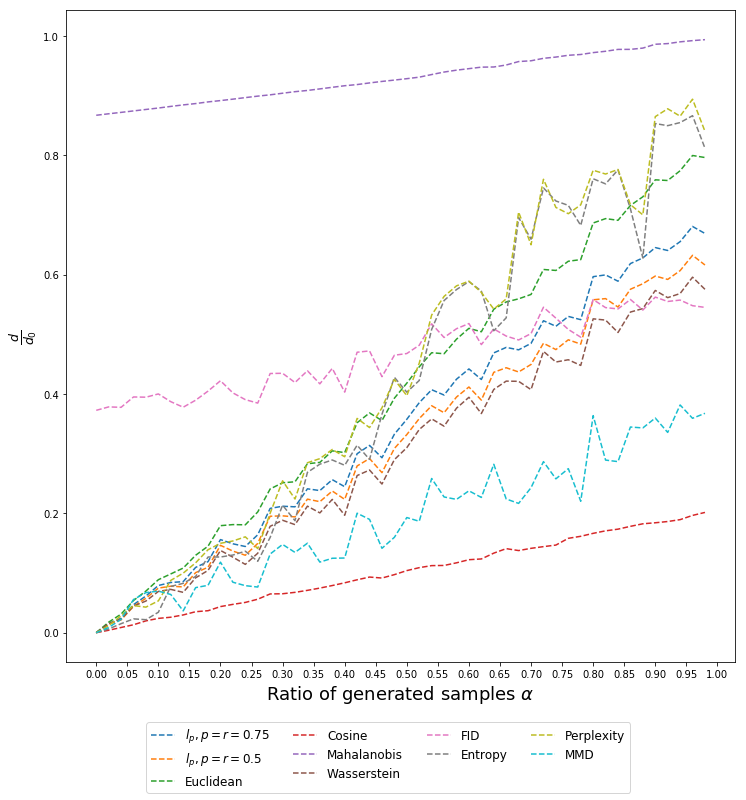

In [44]:
fig = plt.figure(figsize=(12,10))
plt.plot(alphagrid, normalized_man, '--', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
#plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '-.', label='Perplexity')
#plt.plot(alphagrid, normalized_ent_std, '--', label='Entropy')
#plt.plot(alphagrid, normalized_perp_std, '-.', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=20)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.16,-0.21))
plt.tight_layout()
plt.savefig('figures/discriminative/eps/log_1000_1000.eps')
plt.savefig('figures/discriminative/png/log_1000_1000.png')
plt.show()

## Test Discriminative Behavior

### Square Root Transform
### Sample length 100 - 100 samples

In [51]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=69)


Sr1 = np.sqrt(np.array(real_samples).astype(np.float64))
Sr2 = np.sqrt(np.array(real_samples_2).astype(np.float64))

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, Sr2, G1=Sr1, G2=Sr2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
lp, p=0.75, r=0.75:  332435.73841334914
lp, p=0.5, r=0.5:  6396201.766890271
euclidean:  11305.585541703616
cosine:  0.2721220148968765
Mahalanobis:  4.0634652245643625
wasserstein:  712.331285295745
FID:  79893555.7937149
Entropy:  0.71041866062554
Perplexity:  3.7106803001937236
MMD:  1.0643492521064624


In [53]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.sqrt(np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=69)).astype(np.float64))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.sqrt(np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=42)).astype(np.float64))
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=Sr2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [55]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores/d0_cosine
normalized_mah = mah_scores/d0_mah
#normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

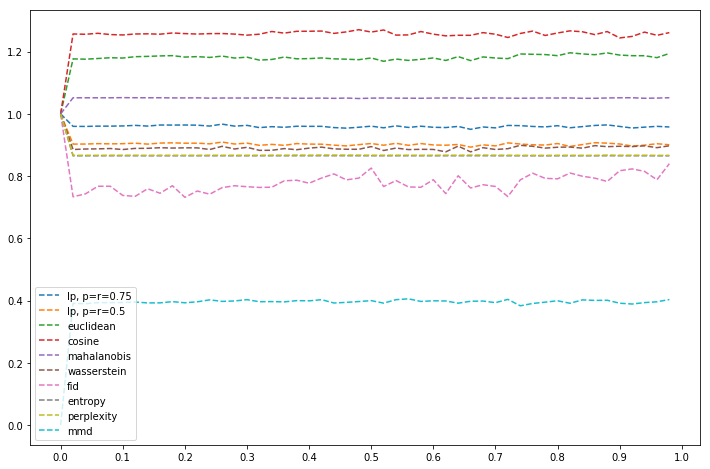

In [56]:

fig = plt.figure(figsize=(12,8))
plt.plot(alphagrid, np.abs(normalized_lp), '--', label='lp, p=r=0.75')
plt.plot(alphagrid, np.abs(normalized_lp_2), '--', label='lp, p=r=0.5')
plt.plot(alphagrid, np.abs(normalized_euc), '--', label='euclidean')
plt.plot(alphagrid, np.abs(normalized_cosine), '--', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, np.abs(normalized_mah), '--', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), '--', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), '--', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), '--', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), '--', label='perplexity')
plt.plot(alphagrid, np.abs(normalized_mmd), '--', label='mmd')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.1))
plt.legend()
plt.show()


## Test Discriminative Behavior on sample length 100 - 1000 Samples

### Square Root Transform

In [38]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=333)

In [39]:
Sr1 = np.sqrt(np.array(real_samples).astype(np.float64))
Sr2 = np.sqrt(np.array(real_samples_2).astype(np.float64))

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, Sr2, G1=Sr1, G2=Sr2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
lp, p=0.75, r=0.75:  327081.89812106325
lp, p=0.5, r=0.5:  6161186.715240366
euclidean:  12681.772151528497
cosine:  0.2780401985519881
Mahalanobis:  4.12522979636387
chi:  3.8830627963204734e+304
wasserstein:  707.5663680267203
FID:  182177096.7371543
Entropy:  0.8500619642954794
Perplexity:  4.396737196488775
MMD:  1.0584007066555023


In [40]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.sqrt(np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=333)).astype(np.float64))
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.sqrt(np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=42)).astype(np.float64))
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=Sr2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [41]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores/d0_cosine
normalized_mah = mah_scores/d0_mah
normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

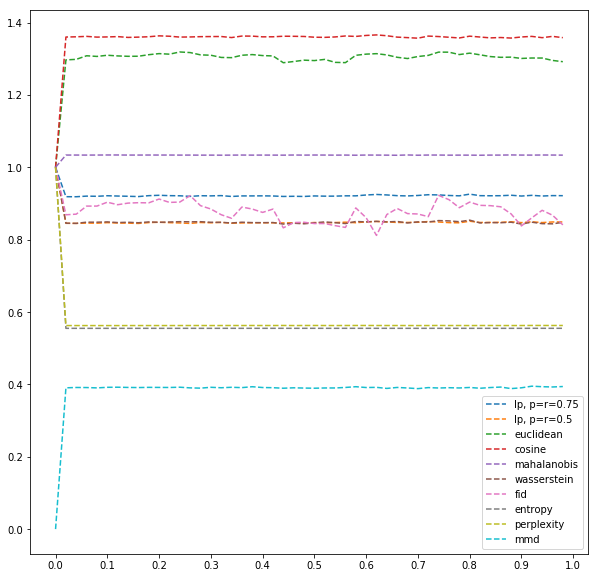

In [42]:
fig = plt.figure(figsize=(10,10))
plt.plot(alphagrid, np.abs(normalized_lp), '--', label='lp, p=r=0.75')
plt.plot(alphagrid, np.abs(normalized_lp_2), '--', label='lp, p=r=0.5')
plt.plot(alphagrid, np.abs(normalized_euc), '--', label='euclidean')
plt.plot(alphagrid, np.abs(normalized_cosine), '--', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, np.abs(normalized_mah), '--', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), '--', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), '--', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), '--', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), '--', label='perplexity')
plt.plot(alphagrid, np.abs(mmd_scores), '--', label='mmd')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.1))
plt.legend()
plt.show()

## Test Discriminative Behavior on transformed data (Log Scaled) sample length 100 with 100 samples

In [50]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=333)

In [51]:
Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(real_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 100
# Log Transform and avoid zeros
epsilon = 1e-10
Sr1 = np.where(Sr1==0, Sr1, np.log(Sr1+epsilon))
Sr2 = np.where(Sr2==0, Sr2, np.log(Sr2+epsilon))

# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
#d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
#print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, Sr2, G1=Sr1, G2=Sr2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
lp, p=0.75, r=0.75:  1303.8286315031928
lp, p=0.5, r=0.5:  25411.79975759178
euclidean:  36.69751292945642
cosine:  0.1332839225660646
chi:  inf
wasserstein:  2.5543097248149795
FID:  148.91445734031637
Entropy:  0.9042649964164612
Perplexity:  5.101462956053815
MMD:  1.0871363979950948


In [52]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=333)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=42)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    Sr1 = np.where(Sr1==0, Sr1, np.log(Sr1+epsilon))
    Sr2 = np.where(Sr2==0, Sr2, np.log(Sr2+epsilon))
    
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    #d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=Sr2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    #mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0


/home/mnewlin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log
/home/mnewlin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [53]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores/d0_cosine
normalized_mah = mah_scores/d0_mah
normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

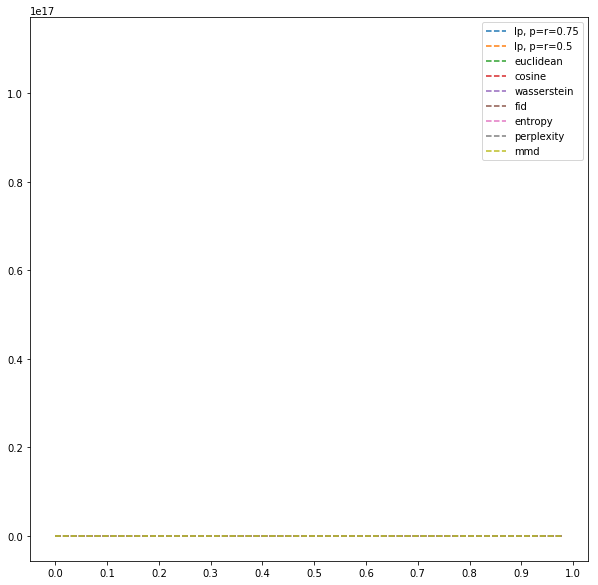

In [56]:
fig = plt.figure(figsize=(10,10))
plt.plot(alphagrid, np.abs(normalized_lp), '--', label='lp, p=r=0.75')
plt.plot(alphagrid, np.abs(normalized_lp_2), '--', label='lp, p=r=0.5')
plt.plot(alphagrid, np.abs(normalized_euc-1), '--', label='euclidean')
plt.plot(alphagrid, np.abs(normalized_cosine-1), '--', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
#plt.plot(alphagrid, np.abs(normalized_mah), '--', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), '--', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), '--', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), '--', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), '--', label='perplexity')
plt.plot(alphagrid, np.abs(normalized_mmd), '--', label='mmd')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.1))
plt.legend()
plt.show()

## Test Discriminative Behavior on transformed data (Log Scaled) sample length 1000 with 100 samples

In [ ]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=100, random_state=333)

In [ ]:
Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(real_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 100
# Log Transform and avoid zeros
epsilon = 1e-10
Sr1 = np.where(Sr1==0, Sr1, np.log(Sr1+epsilon))
Sr2 = np.where(Sr2==0, Sr2, np.log(Sr2+epsilon))

# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr1, Sr2, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
#d0_mmd = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
#print("Perplexity: ", d0_perp)

In [ ]:
alphagrid = np.around(np.arange(0.05,1.0,step=0.05), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 100, random_state=333)).astype(np.float64)
    Sg_t = np.where(Sg_t==0, Sg_t, np.log(Sg_t+epsilon))

    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 100, random_state=42)).astype(np.float64)
    Sg_t2 = np.where(Sg_t2==0, Sg_t2, np.log(Sg_t2+epsilon))
    Sg_t2 = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=Sr2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    print(alpha)

## Fourier Transform Data
## 100 - 1000

In [41]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=1)
fake_samples = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=1)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=2)
fake_samples_2 = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=2)

Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(fake_samples).astype(np.float64)
S_2 = np.array(real_samples_2).astype(np.float64)
G_2 = np.array(fake_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))

# Do FFT on all the samples
Sr1_fft = np.zeros((num_samples, sample_length, num_cols))
Sr2_fft = np.zeros((num_samples, sample_length, num_cols))
S_2_fft = np.zeros((num_samples, sample_length, num_cols))
G_2_fft = np.zeros((num_samples, sample_length, num_cols))

for x in range(num_samples):
    Sr1_fft[x] = fftn(Sr1[x]).real
    
    Sr2_fft[x] = fftn(Sr2[x]).real
    
    S_2_fft[x] = fftn(S_2[x]).real
    
    G_2_fft[x] = fftn(G_2[x]).real
#sample_length = Sr1_fft.shape[1]

print(Sr1_fft.shape)

d0_man = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
print("lp, p=1, r=1: ", d0_man)
d0_lp = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2_fft,Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
#d0_fid = metrics.score_set(Sr2_fft, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
#print("FID: ", d0_fid)
#d0_ent_std = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=True)
#print("Standardized Entropy: ", d0_ent_std)
#d0_perp_std = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=True)
#print("Standardized Perplexity: ", d0_perp_std)
d0_ent = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1_fft, S_2_fft, G1=Sr2_fft, G2=G_2_fft, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

(1000, 100, 10)
lp, p=1, r=1:  564595682586.8625
lp, p=0.75, r=0.75:  2299431996038.49
lp, p=0.5, r=0.5:  43802733114006.7
euclidean:  110787772013.21611
cosine:  0.7248210469906925
Mahalanobis:  1.9948242004302197
wasserstein:  9.536314292631827e-15
Entropy:  1.221422962771612e-15
Perplexity:  2.0169466097286207e-14
MMD:  0.34043359446896476


In [42]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
#fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
ent_scores_std = np.array([])
perp_scores_std = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=1)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=2)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    
    Sg_t_fft = np.zeros((num_samples, sample_length, num_cols))
    Sg_t2_fft = np.zeros((num_samples, sample_length, num_cols))
    
    for x in range(num_samples):
        Sg_t_fft[x] = fftn(Sg_t[x]).real
        Sg_t2_fft[x] = fftn(Sg_t2[x]).real
       
    
    d_man = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
    d_lp = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    #d_fid = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='fid')
    #d_ent_std = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=True)
    #d_perp_std = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=True)
    d_ent = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t_fft, Sr1_fft, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1_fft, S2=S_2_fft,G1=Sg_t_fft, G2=Sg_t2_fft, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    man_scores = np.append(man_scores, d_man)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    #fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    #ent_scores_std = np.append(ent_scores_std, d_ent_std)
    #perp_scores_std = np.append(perp_scores_std, d_perp_std)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [43]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
#normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
#normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
#normalized_ent_std = ent_scores_std/d0_ent_std
#normalized_perp_std = perp_scores_std/d0_perp_std
normalized_mmd = mmd_scores/d0_mmd
normalized_man = man_scores/d0_man

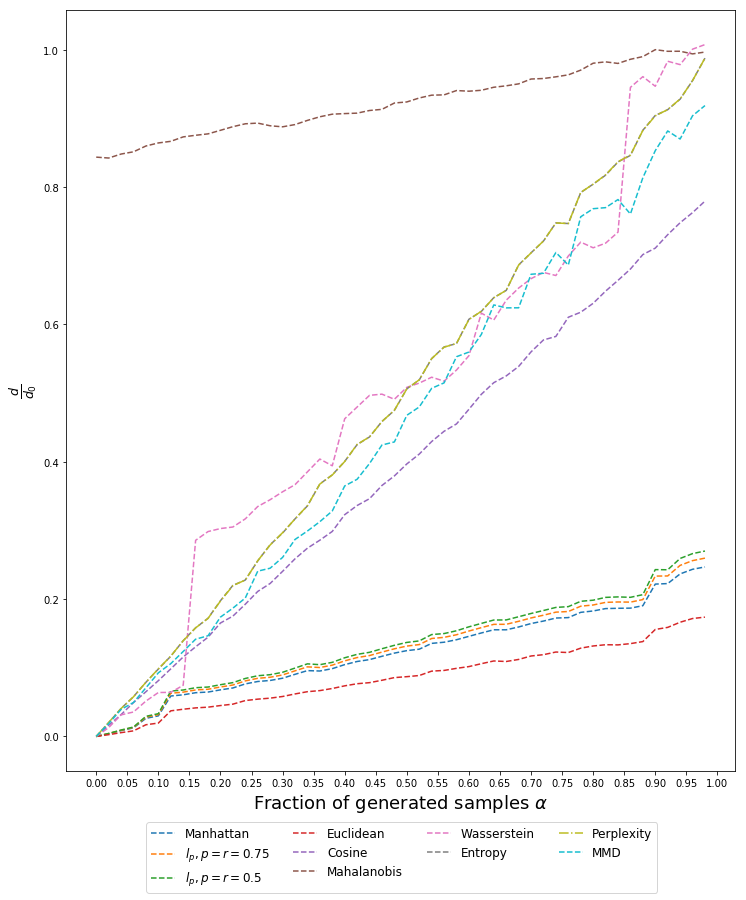

In [45]:
fig = plt.figure(figsize=(12,14))
plt.plot(alphagrid, normalized_man, '--', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
#plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '-.', label='Perplexity')
#plt.plot(alphagrid, normalized_ent_std, '--', label='Entropy')
#plt.plot(alphagrid, normalized_perp_std, '-.', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)
plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.16))
plt.savefig('figures/discriminative/eps/fft_100_1000.eps')
plt.savefig('figures/discriminative/png/fft_100_1000.png')

plt.show()

## FFT 1000-1000